# Deep Learning With PyTorch
**Deep Learning** is a subset of *Machine Learning* where the fundemental structure is a network of inputs, ($\geq 1$) hidden layers, and outputs. The original intuition of deep learning was modelling how the human brain learns; through inter-connected neurons. One of the most popular deep learning frameworks is ***Pytorch*** ,`torch`, sharing similarities with the `numpy` library (instead uses tensors `torch.tensor([[1, 2, 3], [4, 5, 6]])` instead of arrays/matrices).
- Element-wise operations ($X_{a\times b}\cdot Y_{a\times b}$):`x + y` (addition), `x - y` (subtraction), `x * y` (multiplication), `torch.div(x,y)` (division)
- Matrix operations ($X_{a\times b}\cdot Y_{b\times c}$): `x @ y` (multiplication), `torch.linalg.inv(x)` (matrix inverse)

## Neural Network (NN)
### OOP deep learning model

In [ ]:
import torch.nn as nn
import torch.nn.init as init

# OOP model to replace:
# net = nn.Sequential(nn.Linear(9,16), 
#               nn.ReLU(), 
#               nn.Linear(16,8), 
#               nn.ReLU(), 
#               nn.Linear(8,1), 
#               nn.Sigmoid())

class Net(nn.Module):
    def __init__(self): # network definition
        super().__init__()
        self.fc1 = nn.Linear(9,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

    def forward(self, x): # forward pass
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        return x

net = Net()


## solutions for unstable (vanishing/exploding) gradients:
class Net2(Net):
    # Batch normalization: (normalize the layers' outputs, scale and shift normalized outputs using learned parameters)
    # - model learns optimal inputs distribution for each layer
    #   - faster loss decrease
    #   - helps against unstable gradients
    def __init__(self):
        super().__init__()
        self.bn1 = nn.BatchNorm1d(16)
        self.bn2 = nn.BatchNorm1d(8)
        self._weight_initialization()

    # Proper weight initialization: (dependent on activation function)
    # - ensures variance of layer inputs = variance of layer outputs
    # - ensures variance of gradients is the same before and after a layer
    def _weight_initialization(self):
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity="sigmoid")

    # Activation functions with non-zero gradients for negative values:(ELU, etc.)
    # - help against dying neurons (become 0 and never change after)
    # - average output > 0 and thereby help against vanishing gradients
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.elu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.elu(x)
        # = nn.functional.leaky_relu(x, negative_slope=0.05) # ReLU where slope for x < 0 is != 0
        x = self.fc3(x)
        x = nn.functional.sigmoid(x)
        return x

### DataLoader setup

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CsvDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        df = pd.read_csv(csv_path)
        self.data = df.to_numpy()

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, indx):
        features = self.data[indx, :-1]
        label = self.data[indx, -1]
        return features, label
    
train_dataset = CsvDataset('train.csv')
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

### Model Training

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.95) # stochastic gradient descent
#         = optim.Adagrad(net.parameters(), lr=0.01) # adaptive gradient descent (different learning rate for each parameter)
#         = optim.RMSprop(net.parameters(), lr=0.01) # root mean square propagation (update for each parameter based on the size of previous gradient)
#         = optim.Adam(net.parameters(), lr=0.01) # adaptive moment estimation (RMSprop + gradient momentum)

for epoch in range(1000):
    for features, label in train_dataloader:
        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, label.view(-1,1))
        loss.backward()
        optimizer.step()

### Evaluation Procedure

In [ ]:
import torch
from torchmetrics import Accuracy

test_dataset = CsvDataset('test.csv')
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

acc = Accuracy(task="binary")

net.eval()
with torch.no_grad():
    for features, label in test_dataloader:
        outputs = net(features)
        pred = (outputs >= 0.5).float()
        acc(pred, label.view(-1,1))

accuracy = acc.compute()
print(f"accuracy: {accuracy}")

In multi-class classification, seperate precision (fraction of cumulus-prediction that were correct) and recall (fraction of all cumulus examples correctly predicted) exist for each class. These then can be analysed by aggregating the scores; globally (micro average), per class (macro average), weighted mean per class (weighted average).

In [ ]:
from torchmetrics import Precision, Recall

precision = Precision(task="multiclass", num_classes=7, average="macro")
recall = Recall(task="multiclass", num_classes=7, average="weighted")
# ...
{k: recall[v].item() for k,v in test_dataset.class_to_idx.items()}

## Convolutional NN

### Data Augmentation

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Generating more data by applying random transformations to the original images
# - increase size and diversity of training set
# - improve model robustness
# - reduces overfitting
# Note that transformation need to be logical to the data and task (i.e. if designed to detect lemons vs. limes, 
# cannot alter the color as label would not be accurate anymore)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    # ...
    transforms.ToTensor(),
    transforms.Resize((64,64))
])
train_dataset = ImageFolder("./train", transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
image, label = next(iter(train_dataloader))
image = image.squeeze().permute(1, 2, 0) # alter dimensions of image to correctly display it

# Note that there should be no data augmentation for test data

### Convolutional Layers

In [ ]:
## Normal Convolutional Layers
# Slide overlapping filter(s) of parameters over the input, performing convolution (dot-product) at each position resulting in a feature map (one 
# filter = one feature map); preserving spatial patters from input, and uses fewer parameters than linear layers. Activation functions are then 
# applied to each feature map (similar to normal NN), and all maps are combined to form an output.
# - a frame of 0s can be added to convolutional layer's input to ensure border pixels are treated equally to others.

## MaxPooling
# Slide non-overlapping window(s) over the input, and at each position retaining only the maximum value (used after convolutional layers to reduce 
# spatial dimensions).

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.cl1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.cl2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.cl3 = nn.MaxPool2d(kernel_size=2)
        self.cl4 = nn.Flatten()

        self.fc1 = nn.Linear(16*16*64,num_classes)

    def forward(self, x): # forward pass
        x = self.cl1(x) # 64x64x3 -> 64x64x32
        x = nn.functional.elu(x) 
        x = self.cl3(x) # 64x64x32 -> 32x32x32
        x = self.cl2(x) # 32x32x32 -> 32x32x64
        x = nn.functional.elu(x)
        x = self.cl3(x) # 32x32x64 -> 16x16x64
        x = self.cl4(x) # 16x16x64 -> 16384
        x = self.fc1(x)
        return x

## Sequential NN
### Creating Sequences

In [ ]:
import numpy as np
from torch.utils.data import TensorDataset

def createSequence(df, seq_length):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i:(i+seq_length),1]
        y = df.iloc[(i+seq_length),1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_train, Y_train = createSequence(df, 5)
train_dataset = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(Y_train).float(),
)

### Recurrent Neural Network (RNN) Cell
Where Feed-forward networks pass data in one direction, through all the layers, to the outputs; Recurrent neural networks also have connections pointing back. At each time-step $t$ a neuron has an input $X_t$, and output $Y_t$, and a hidden state $h_t$ (can be thouht of as maintaining short-term memory). This can be better visualised by showing the neuron once per time-step, called unrolling a neuron through time:

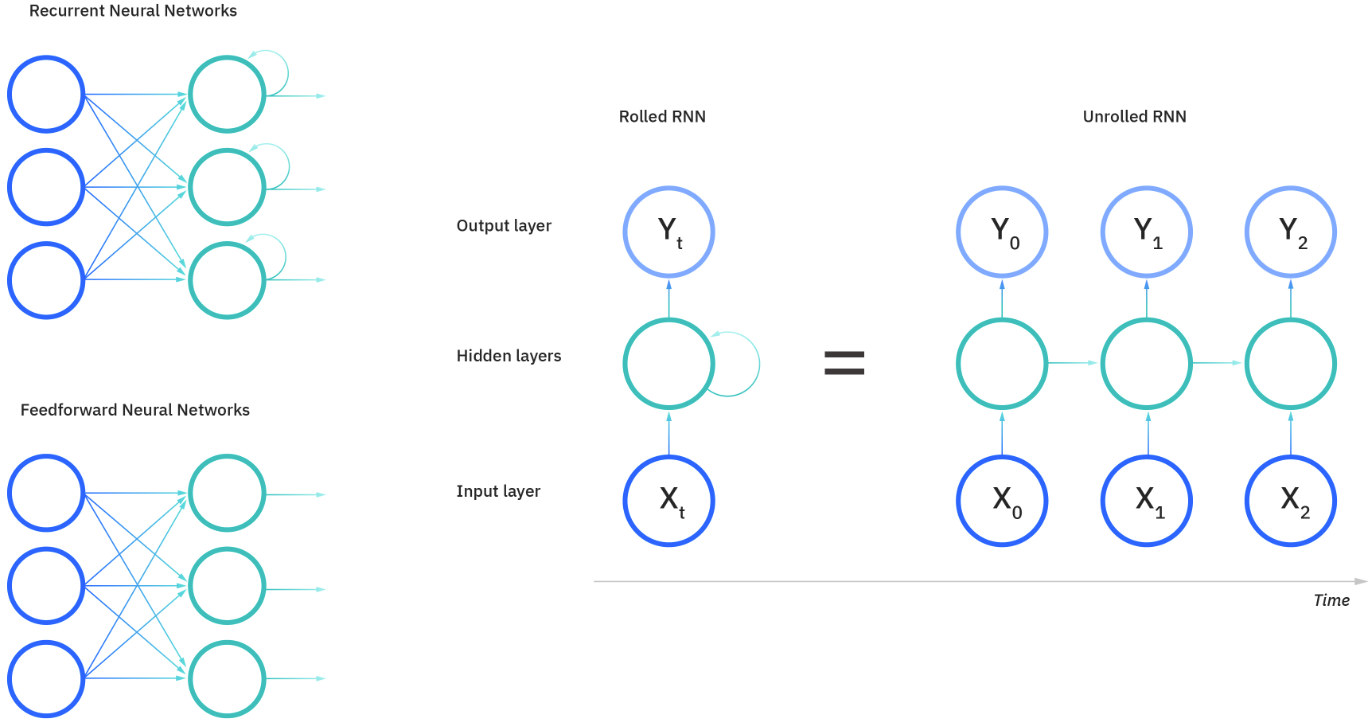

This way it can be seen that the initial neuron will recieve inputs $X_0$, and $h_0$ (commonly set to $0$); and produce outputs $Y_0$, and $h_1$. This step will then repeat with the new inputs $X_1$, and $h_1$, continuing until the end of the input sequence. Depending on the lengths of input an output sequences, 4 architecture types can be generated:

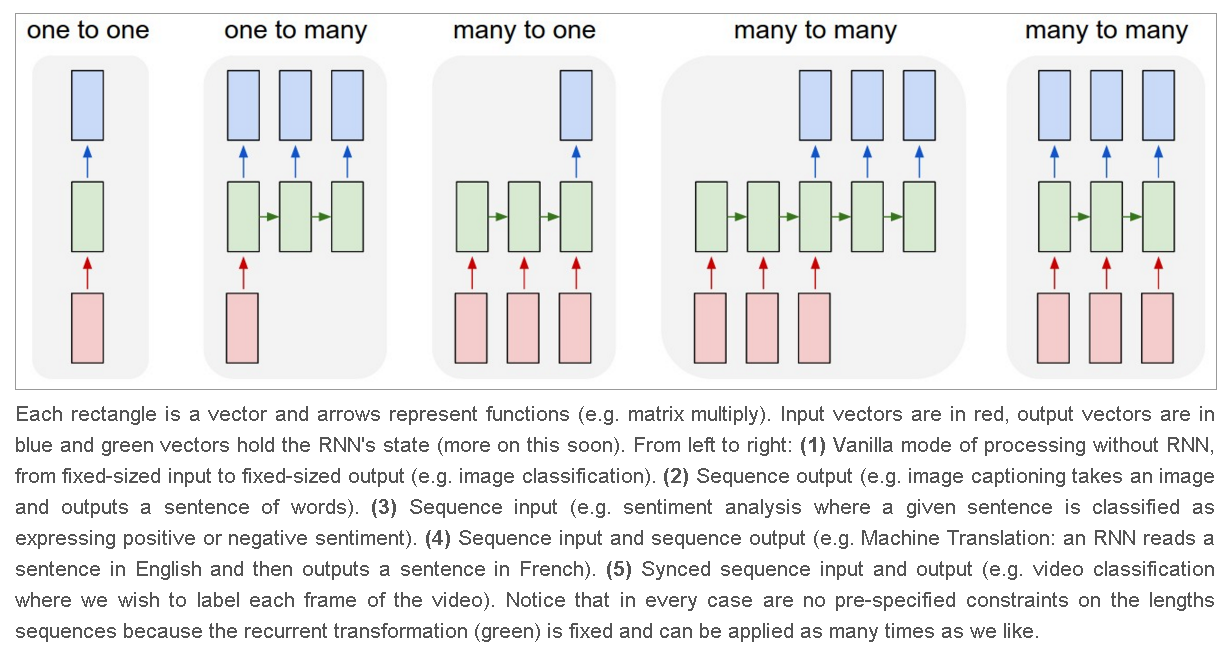

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.rnn1 = nn.RNN(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True)
        self.fc1 = nn.Linear(32,1)

    def forward(self, x): # forward pass
        # Reccurent layers expect input in the shape (batch_size, seq_length, num_features) and 
        # .view()/.squeeze() would need to occur to shape the data correctly
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.rnn1(x, h0)
        x = out[:, -1, :]
        x = self.fc1(x)
        return x

### Long Short-Term Memory (LSTM) Cell
The most complex of the three; it has short-term state $h$, long-term state $c$, and input $x$ which go through a *forget* (what to remove from long-term memory), *input* (what to save to long-term memory), and *output* (what to return at the current time step) gates before returning the outputs.

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.lstm1 = nn.LSTM(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True)
        self.fc1 = nn.Linear(32,1)

    def forward(self, x): # forward pass
        h0 = torch.zeros(2, x.size(0), 32)
        c0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.lstm1(x, (h0, c0))
        x = out[:, -1, :]
        x = self.fc1(x)
        return x

### Gated Recurrent Unit (GRU) Cell
GRU cell is a simplified version of the LSTM cell, merging the log-term and short-term memories into a single hidden state (does not use *output* gate)

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes): # network definition
        super().__init__()
        self.rnn1 = nn.GRU(
            input_size=1, 
            hidden_size=32, 
            num_layers=2, 
            batch_first=True)
        self.fc1 = nn.Linear(32,1)

    def forward(self, x): # forward pass
        h0 = torch.zeros(2, x.size(0), 32)
        out, _ = self.rnn1(x, h0)
        x = out[:, -1, :]
        x = self.fc1(x)
        return x

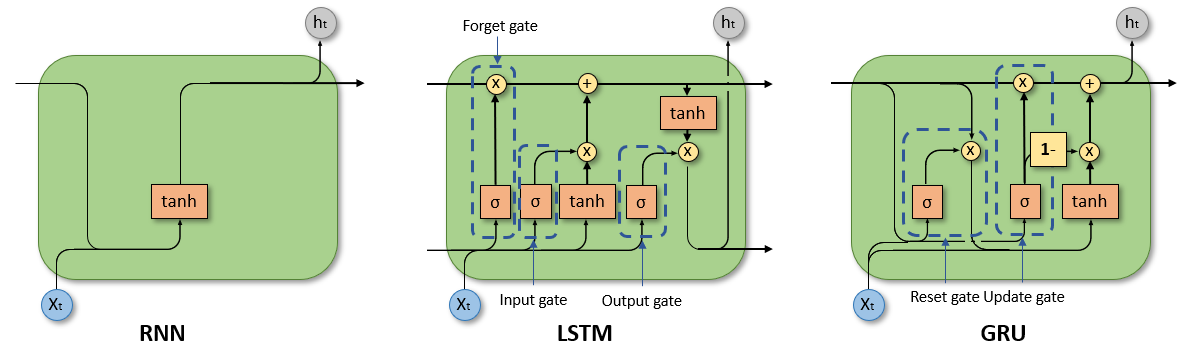

Note that RNNs are rarely used anymore due ot the better performances (short-term memory problem) of LSTM and GRU, and while their performance depends greatly on the task and data, it is worth noting that GRU calculations are simplier and easier than LSTM.

## Multi-Input Models
This model category instead of taking in a single input (vector, text, image, etc.), takes two (or more) augmented versions of the same input entity and learns the association across the version; thereby learning that they represent the same object (comparing passport photo with the photo taken at the airport).

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

class OmniglotDataset(Dataset):
    def __init__(self, path):
        super().__init__()

        # generate database if doesn't exist
        torchvision.datasets.Omniglot(root=path, download=True, transform=torchvision.transforms.ToTensor())

        self.transform = transforms.Compose([
            transforms.RandomRotation(20),
            transforms.RandomAutocontrast(),
            transforms.ToTensor(),
            transforms.Resize((64,64)),
        ])

        samples = []
        language_path = f'{path}/omniglot-py/images_background'
        languages = os.listdir(language_path)
        character_index = 0
        for index_i, language in enumerate(languages):
            characters = os.listdir(language_path + '/' + language)
            for index_j, character in enumerate(characters):
                for img_name in os.listdir(language_path + '/' + language + '/' + character):
                    img_path = f'{language_path}/{language}/{character}/{img_name}'
                    alph = torch.tensor([1 if index_i == i else 0 for i in range(0, len(languages))]).float()
                    label = torch.tensor([1 if character_index == i else 0 for i in range(0, 964)]).float()
                    samples.append((img_path, alph, label))
                character_index += 1
        self.samples = samples

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, indx):
        img_path, alph, label = self.samples[indx]
        img = Image.open(img_path).convert('L')
        tranformed_img = self.transform(img)
        return tranformed_img, alph, label
    
full_dataset = OmniglotDataset('./data')
train_dataset, test_dataset = random_split(full_dataset, [0.8, 0.2])

In [ ]:
import torch.nn as nn

class OmniglotNet(nn.Module):
    def __init__(self): # network definition
        super().__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(32*32*32, 128),
            nn.ELU()
        )

        self.alphabet_layer = nn.Sequential(
            nn.Linear(30, 8),
            nn.ELU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128+8, 964)
        )

    def forward(self, img, alph): # forward pass
        img = self.image_layer(img)
        alph = self.alphabet_layer(alph)
        x = torch.cat((img, alph), dim=1)
        x = self.classifier(x)
        return x

In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

net = OmniglotNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
for epoch in range(50):
    pbar = tqdm(total=len(train_dataloader))
    for index, (image, alphabet, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = net(image, alphabet)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()
    print(loss.detach().numpy())

In [ ]:
from torchmetrics import Accuracy

acc = Accuracy(task='multiclass', num_classes=964)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

net.eval()
with torch.no_grad():
    for index, (image, alphabet, label) in enumerate(test_dataloader):
        output = net(image, alphabet)
        pred = torch.softmax(output, 1)
        acc(pred, label)
    print(f"Character accuracy: {acc.compute()}")

## Multi-Output Models
Similar to Multi-input, these architectures generates multiple outputs from the same input; with the simplest use case being predicting two variables from a single input. This architecture can also be used as a form of regularization to boost the robustness of the network, and ensure that the early parts of the model are learning useful features (extra outputs along the NN, predicting the same targets after each block).

- note that each output needs to have its own individual loss with the model's overall loss being the sum of all output losses. These however must be on the same scale. Once nornmalization has occured, the importance of each output can be set by adding weights to each normalised loss.  
### Bounding Box
A bounding box describes an object's spatial location using $(x_{\min},y_{\max})$, and $(x_{\max},y_{\min})$ box coordinates. Therefore, a simple model would be to create a model which classifies an object and generates its bounding box (multi-output model). Evaluation of predicted bounding box can be done through Intersection over Union (IoU) (Area of Intersection / Area of Union), with IoU > 0.5 being considered a good prediction.

- Object recognition models may generate many bounding boxes and some of them may be overlapping near duplicates. Non-max suppression is a common technique to select the most relevant bounding boxes (discard boxes with low confidence score or low IoU).

#### R-CNN Models
R-CNN is a family (R-CNN, Fast-CNN, Faster CNN) of region based convolutional models for object detection. These 1st generate many region  proposals (potential bounding boxes that may contain objects), which are then passed onto CNNs to extract features (class, bounding boxes, etc.) from each region; finally, the class and bounding boxes are used to predict the class (and bounding box) for the regions.

It is common practice to use pre-trained models for the "backbone", core CNN architecture responsible for feature extraction (region proposal and object detection).

In [ ]:
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

vgg = vgg16(weights=VGG16_Weights.DEFAULT)
backbone = nn.Sequential(
    # .features extracts only the convolutional layers form vgg
    # .children() extracts all layers from block
    *list(vgg.features.children())
    # *list() upacks the elements from the list
)
input_dimension = backbone[0].in_features
classifier = nn.Sequential(
    nn.Linear(input_dimension, 512),
    # ...
)
box_regressor = nn.Sequential(
    nn.Linear(input_dimension, 512),
    nn.ReLU(),
    nn.Linear(512, 4)
)

##### Faster R-CNN
This is an advanced version of R-CNN, where an image goes through a convolutional (backbone) layer, a Region Proposal Network (RPN) to generate bounding box proposals, and finally a classification adn regressor NNs to produce a prediction.

The RPN stage generates a set of anchor boxes (pre-defined bounding box templates) of different sizes and aspect ratios on top of the backbone's output; then it predicts whether an object is contained within each box, and its coordinates. All this is inserted into a Region of Interest (RoI) Pooling, which resizes the RPN proposal to a fixed size for fully connected NN layers (determine classification adn final boudnign box)

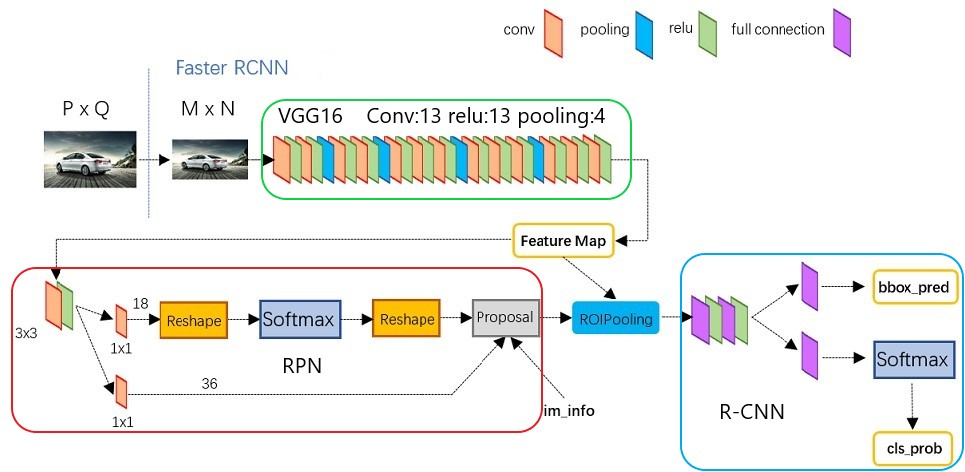

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128),),
    aspect_ratios=((0.5,1.0,2.0),)
)

from torchvision.ops import MultiScaleRoIAlign
roi_pooler = MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=7,
    sampling_ratio=2
)

backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280
num_classes = 7

from torchvision.models.detection import FasterRCNN
model = FasterRCNN(
    backbone=backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

#### Image Segmentation
Computer vision task which partitions an mage into multiple sements on the pixel level (each pixel is assigned to a particular segment).

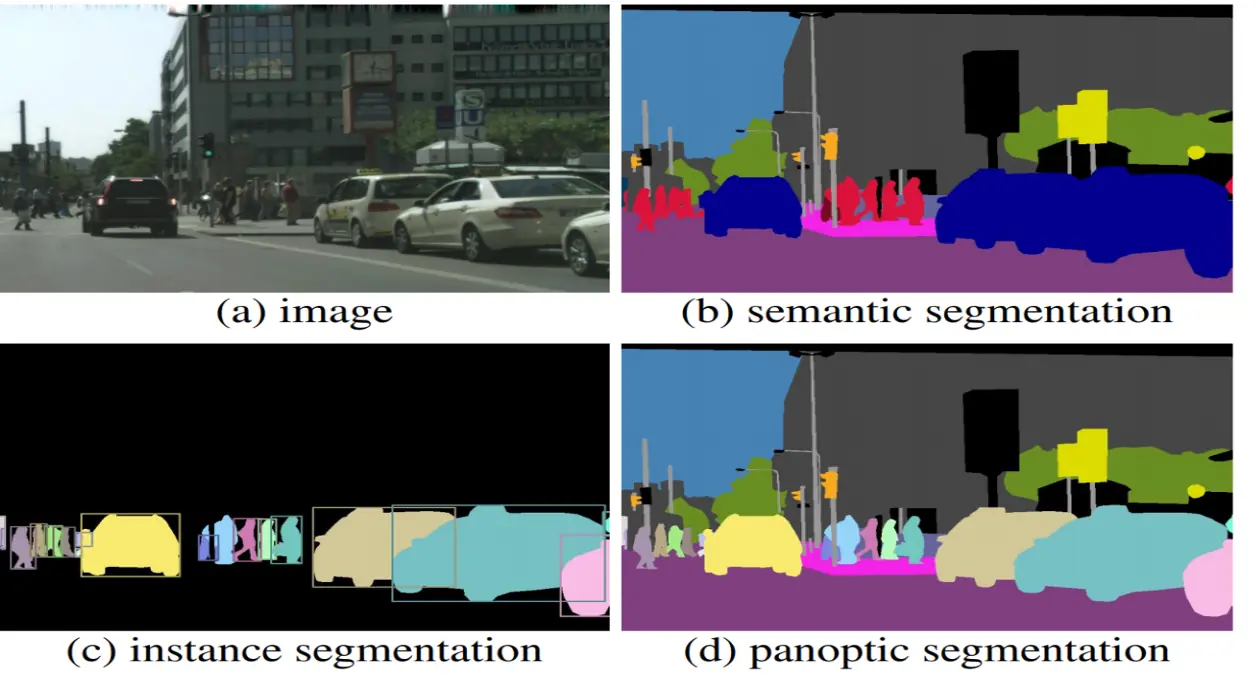

##### Semantic Segmentation
This type of segmentation assigns each pixel into a class (all pixels belonging to the same class are treated equally). This task mostly consists of training a model to create a set of binary-pixel-level masks for each class; with the most popular architecture being U-Net. 

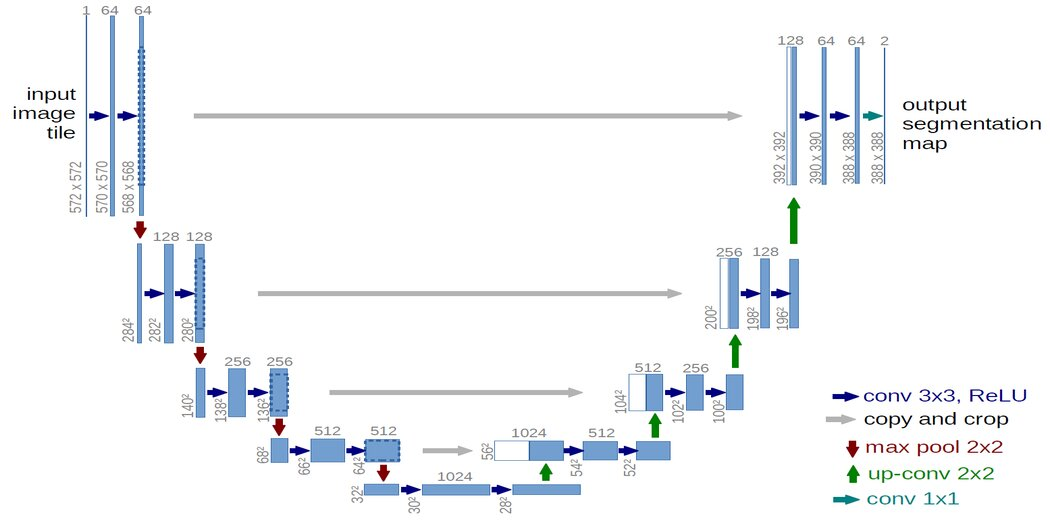

The U-Net architecture consists of an encoder, which captures the image context through (down-sampling) a series of convolutional and pooling layers (reducing height and width while increasing depth of feature maps); and a decoder, which mirrors the encoder and gradually up-samples (making feature maps shallower with increased height and width) the feature maps using *transposed convolutional* layers (insert 0s between/around input feature map, and then perform regular convolution layer). Therefore, generating a result of equal dimensions as the input, allowing to predict pixel-wise classes. 

- Skip connections (direct links between different layers in network) between each level of down-sampling and up-sampling are used to ensure that details are not lost in downsampling steps.

In [ ]:
import torch.nn as nn
class UNet(nn.Module):
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels),
            nn.ReLU(inplace=True)
        )
    
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.upC1 = nn.ConvTranspose2d(512,256, kernel_size=2, stride=2)
        self.upC2 = nn.ConvTranspose2d(256,128, kernel_size=2, stride=2)
        self.upC3 = nn.ConvTranspose2d(128,64, kernel_size=2, stride=2)

        self.dec1 = self.conv_block(512, 256)
        self.dec2 = self.conv_block(256, 128)
        self.dec3 = self.conv_block(128, 64)
        self.out = nn.Conv2d(64, out_channels, kernel_size=3)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x3 = self.enc3(self.pool(x2))
        x4 = self.enc4(self.pool(x3))

        x = self.upC1(x4)
        x = torch.cat([x,x3], dim=1)
        x = self.dec1(x)
        x = self.upC2(x)
        x = torch.cat([x,x2], dim=1)
        x = self.dec2(x)
        x = self.upC3(x)
        x = torch.cat([x,x1], dim=1)
        x = self.dec3(x)
        return self.out(x)

##### Instance Segmentation
This type of segmentation goes beyond semantic, distinguishing between different instances of the same class. Mask R-CNN extends Faster R-CNN by adding instance segmentation instead of bounding box (retaining nearly identical architecture except for optimisation task).  

##### Panoptic Segmentation
This type combines semantic and instance segmentation; assigning a unique label to each instance of an object while also classifying background regions. The general workflow takes semantic masks and combines them into a single (multi-class) mask, then generate an instance masks and iterate over them, overlay detected objects into the semantic mask.

## Generative Adversarial Networks (GANs)
GANs are neural networks which can generate new samples based on training data. The architecture consists of a **generator** which learns to produce plausible data (art forger), becoming the negative training examples for the **discriminato**; which learns to distinguish between real and fake data, penalizing the generator for producing implausible results.

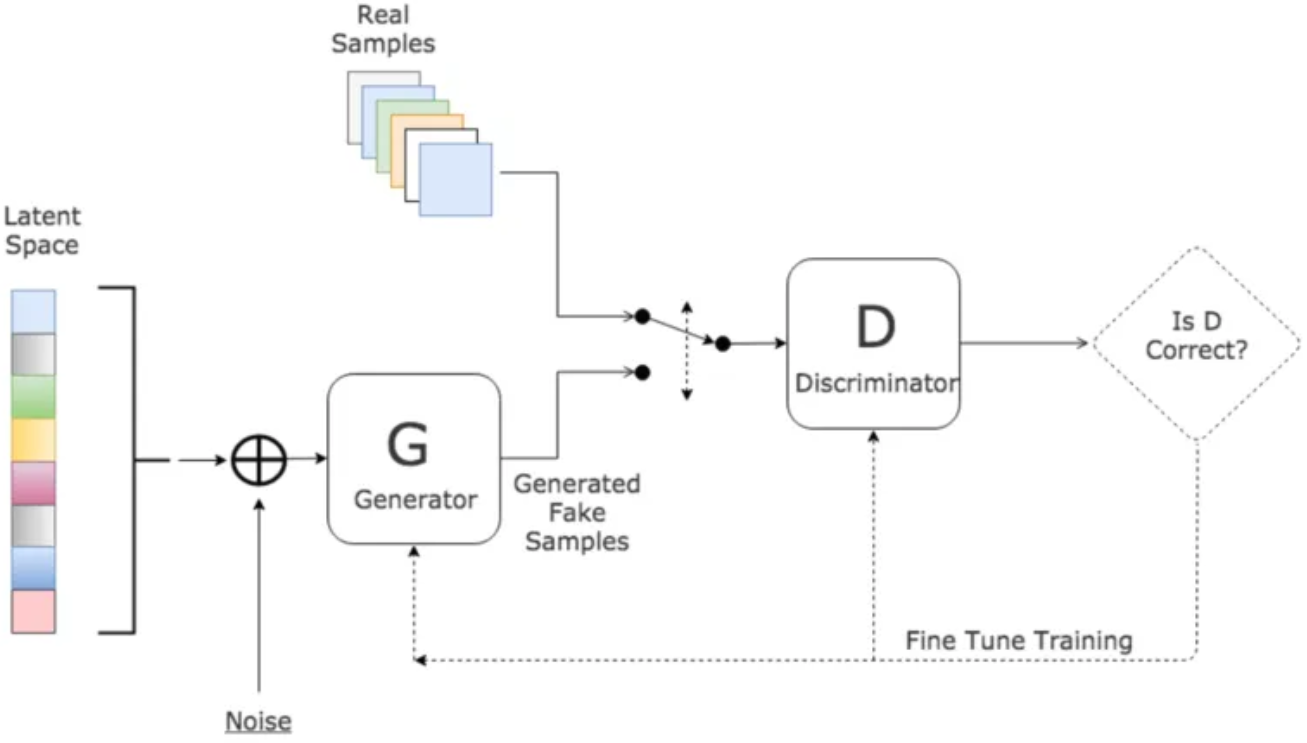

When training begins, the generator produces obviously fake data, and the discriminator quickly learns to tell that it's fake. But as training progresses, the generator gets closer to producing output that can fool the discriminator; and if generator training goes well, the discriminator gets worse at telling the difference between real and fake. It starts to classify fake data as real, and its accuracy decreases.

In [ ]:
import torch.nn as nn
class Generator(nn.Module):
    def gen_block(in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(inplace=True)
        )
    
    def __init__(self, in_dim, out_dim):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            self.gen_block(in_dim, 256),
            self.gen_block(256, 512),
            self.gen_block(512, 1024),
            nn.Linear(1024, out_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.generator(x)
    
class Discriminator(nn.Module):
    def disc_block(in_dim, out_dim):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.LeakyReLU(0.2)
        )
    
    def __init__(self, in_dim):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            self.disc_block(in_dim, 1024),
            self.disc_block(1024, 512),
            self.disc_block(512, 256),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.discriminator(x)

### Deep Convolutional GAN
Convolutional (and transposed) layer provide better results when processing images than basic linear layers; however, training GANs is often unstable and simply swapping linear layers for convolutions is not enought. DCGAN provides guidlines to use convolutions in GAN:

- only use strided convolutions (stride > 1)
- do not use any linear or pooling layers
- use batch normalization
- use ReLU activation in the generator (except last layer which uses tanh)
- use leaky ReLU activation in the discriminator

In [ ]:
import torch.nn as nn
class Generator(nn.Module):
    def gen_block(in_dim, out_dim, kernel_size, stride):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(out_dim),
            nn.ReLU()
        )
    
    def __init__(self, in_dim, kernel_size, stride):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.generator = nn.Sequential(
            self.gen_block(in_dim, 256, kernel_size, stride),
            self.gen_block(256, 512, kernel_size, stride),
            self.gen_block(512, 1024, kernel_size, stride),
            nn.ConvTranspose2d(1024, 3, kernel_size=kernel_size, stride=stride),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(len(x), self.in_dim, 1, 1)
        return self.generator(x)
    
class Discriminator(nn.Module):
    def disc_block(in_dim, out_dim, kernel_size, stride):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2)
        )
    
    def __init__(self, kernel_size, stride):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            self.disc_block(3, 512, kernel_size, stride),
            self.disc_block(512, 1024, kernel_size, stride),
            nn.Conv2d(1024, 1, kernel_size=kernel_size, stride=stride),
        )

    def forward(self, x):
        x = self.discriminator(x)
        return x.view(len(x), -1)

In [ ]:
gen = Generator(16, 3, 2)
gen_opt = optim.Adam(gen.parameters(), lr=0.01)
def gen_loss(gen, disc, num_images, z_dim):
    criterion = nn.BCEWithLogitsLoss()
    noise = torch.rand(num_images, z_dim)
    fake = gen(noise)
    disc_pred = disc(fake)
    return criterion(disc_pred, torch.ones_like(disc_pred))

disc = Discriminator(3, 2)
disc_opt = optim.Adam()
def disc_loss(gen, disc, real, num_images, z_dim):
    criterion = nn.BCEWithLogitsLoss()
    noise = torch.rand(num_images, z_dim)
    fake = gen(noise)
    disc_pred_fake = disc(fake)
    disc_pred_real = disc(real)
    return (
            criterion(disc_pred_fake, torch.zeros_like(disc_pred_fake)) + 
            criterion(disc_pred_real, torch.ones_like(disc_pred_real))
        ) / 2


for epoch in range(10):
    for real in train_dataloader:
        cur_batch_size = len(real)
        disc_opt.zero_grad()
        disc_loss(gen, disc, real, cur_batch_size, z_dim=16)
        disc_loss.backward()
        disc_opt.step()

        gen_opt.zero_grad()
        gen_loss(gen, disc, cur_batch_size, z_dim=16)
        gen_loss.backward()
        gen_opt.step()

### Fre'chet Inception Distance (FID)
A common evaluation metric for GANs; FID uses Inception (image classification model) to extract features from both real and fake image samples, calculating their mean, covariances, and the Fre'chet Distance (distance measure between probability distributions) assuming the sample features have a normal distribution (FID < 10 is generally considered good).


In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=64)
fid.update((fake*255).to(torch.uint8), real=False)
fid.update((real*255).to(torch.uint8), real=True)
fid.compute()